### Mounting google drive for final data

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/hate_speech/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

### Reading data in CSV format

In [3]:
data =  pd.read_csv('gdrive/My Drive/hate_speech/final_data.csv')
data.head()

,Unnamed: 0,tweet_lower,handle_count,handle_removed,url_removed,special_char_removed,single_hashtag_removed,tweets_length,lemmatized,tweet_stopwords_removed,target
0,0,brand new big flowdan in the emails #horrorshow,0,brand new big flowdan in the emails #horrorshow,brand new big flowdan in the emails #horrorshow,brand new big flowdan in the emails #horrorshow,brand new big flowdan in the emails #horrorshow,49,brand new big flowdan in the email #horrorshow,brand new big flowdan email #horrorshow,0
1,1,@mckinley719 fuck bitches get money,1,fuck bitches get money,fuck bitches get money,fuck bitches get money,fuck bitches get money,23,fuck bitch get money,fuck bitch get money,1
2,2,rt @_____al: exactly. don't be gettin no addit...,1,rt : exactly. don't be gettin no additional pu...,rt : exactly. don't be gettin no additional pu...,rt exactly don't be gettin no additional pu...,rt exactly don't be gettin no additional pu...,95,rt exactly do n't be gettin no additional puss...,exactly n't gettin additional pussy soft ass t...,1
3,3,niccas use to be like you always tryn pull a f...,0,niccas use to be like you always tryn pull a f...,niccas use to be like you always tryn pull a f...,niccas use to be like you always tryn pull a f...,niccas use to be like you always tryn pull a f...,77,niccas use to be like you always tryn pull a f...,niccas use like always tryn pull finesse duh n...,1
4,4,@munafal777 karma is a bitch,1,karma is a bitch,karma is a bitch,karma is a bitch,karma is a bitch,17,karma be a bitch,karma bitch,1


### Selecting only 2 columns that are important for model building

In [4]:
data = data[['tweet_stopwords_removed', 'target']]
data

,tweet_stopwords_removed,target
0,brand new big flowdan email #horrorshow,0
1,fuck bitch get money,1
2,exactly n't gettin additional pussy soft ass t...,1
3,niccas use like always tryn pull finesse duh n...,1
4,karma bitch,1
...,...,...
40211,dress ready,0
40212,many bitch get rabies hate hoppin' woman #stan...,1
40213,#lesmiserables gang ready westendlive #lesmise...,0
40214,dumb ugly stupid bullshit ass bitch,1


In [5]:
# dropping null values
data = data.dropna()
data.reset_index(inplace=True, drop=True)
data

,tweet_stopwords_removed,target
0,brand new big flowdan email #horrorshow,0
1,fuck bitch get money,1
2,exactly n't gettin additional pussy soft ass t...,1
3,niccas use like always tryn pull finesse duh n...,1
4,karma bitch,1
...,...,...
40175,dress ready,0
40176,many bitch get rabies hate hoppin' woman #stan...,1
40177,#lesmiserables gang ready westendlive #lesmise...,0
40178,dumb ugly stupid bullshit ass bitch,1


In [6]:
data.isna().sum()

tweet_stopwords_removed    0
target                     0
dtype: int64

In [7]:
print(len(data[data['target'] == 1]))
print(len(data[data['target'] == 0]))

20603
19577


In [8]:
df = data.copy()
df

,tweet_stopwords_removed,target
0,brand new big flowdan email #horrorshow,0
1,fuck bitch get money,1
2,exactly n't gettin additional pussy soft ass t...,1
3,niccas use like always tryn pull finesse duh n...,1
4,karma bitch,1
...,...,...
40175,dress ready,0
40176,many bitch get rabies hate hoppin' woman #stan...,1
40177,#lesmiserables gang ready westendlive #lesmise...,0
40178,dumb ugly stupid bullshit ass bitch,1


## Splitting train, test, val datasets

In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [10]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

32144 training examples
4018 validation examples
4018 test examples


### Preparing dataset for model

In [11]:
def df_to_dataset(df, shuffle=True, batch_size=256):
  df = df.copy()
  labels = df.pop('target')
  df = df['tweet_stopwords_removed']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data= df_to_dataset(train)
val_data= df_to_dataset(val)
test_data= df_to_dataset(test)

In [13]:
list(train_data)[0]

(<tf.Tensor: shape=(256,), dtype=string, numpy=
 array([b'need hoe', b'bitch tweet answer', b'comic make #smile laugh',
        b'bitch self esteem build like principle build instagram meme',
        b"week ago yall hoe n't suck dick yall pro huj",
        b'server lag ranked match constantly multiple rank #disappoint',
        b'never lie never cry never die die love friend love hoe yellow slut call gold',
        b'learn great asia torres take note bitch',
        b'leave delivered smh #noreadrecipetson #curve',
        b'fusionmadness lmao #motivation',
        b'girl know bitch like boyfriend',
        b'kind beautiful #wink #weekend #smile #kiss',
        b'think pussy wet kitten drown two day ago',
        b'bitch need bring ass fucking practice', b'bitch ass buddy pmo',
        b'eminem say call faggot cause hate pussy',
        b'fuck fuck hate guy insurance policy trash omg square fuck',
        b'see fuck bitch fuck bitch also',
        b'good time #friend #friend #fun #tagsf

## Using nnlm-en-dim50 model

Token based text embedding trained on English Google News 7B corpus.




In [14]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [15]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(256, 50), dtype=float32, numpy=
array([[-0.03860819, -0.32214642, -0.13782533, ...,  0.19841729,
         0.21087576,  0.06910939],
       [ 0.25738963, -0.14863992, -0.07130796, ...,  0.13099612,
         0.23738126, -0.02596871],
       [ 0.2520633 , -0.355566  , -0.40394422, ...,  0.02572255,
         0.22821315,  0.09927262],
       ...,
       [ 0.5132942 , -0.31024072,  0.21904469, ...,  0.15691812,
         0.15693112,  0.44100344],
       [ 0.06495484, -0.2244325 , -0.47533002, ..., -0.19148125,
         0.28530994,  0.2756733 ],
       [ 0.07677812, -0.01887227, -0.34017456, ...,  0.04699153,
         0.24548225, -0.06460755]], dtype=float32)>

## Final Model for hate speech classification

In [16]:
# model architecture

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [17]:
# defining callback for on epoch end

class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.997 and logs.get('val_accuracy') > 0.975:
      print('\n\n\nTraining Stopped. Accuracy reached 99.7% and Validation accuracy reached 97.5%\n\n')
      self.model.stop_training = True

callback = mycallback()

In [18]:
# compiling model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [19]:
# testing untrained model on train data for accuracy

model.evaluate(train_data)

126/126 [==============================] - 3s 7ms/step - loss: 0.6832 - accuracy: 0.6684


[0.6831768155097961, 0.668367326259613]

In [20]:
# testing untrained model on validation data for accuracy

model.evaluate(val_data)

16/16 [==============================] - 0s 9ms/step - loss: 0.6833 - accuracy: 0.6725


[0.6833395957946777, 0.6724738478660583]

In [21]:
# training model for 10 epoch but with defined callback

history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=callback)

Epoch 1/100
126/126 [==============================] - 7s 43ms/step - loss: 0.2382 - accuracy: 0.9111 - val_loss: 0.0961 - val_accuracy: 0.9684
Epoch 2/100
126/126 [==============================] - 4s 32ms/step - loss: 0.0737 - accuracy: 0.9769 - val_loss: 0.0727 - val_accuracy: 0.9761
Epoch 3/100
126/126 [==============================] - 4s 34ms/step - loss: 0.0384 - accuracy: 0.9905 - val_loss: 0.0757 - val_accuracy: 0.9786
Epoch 4/100
126/126 [==============================] - 4s 32ms/step - loss: 0.0251 - accuracy: 0.9948 - val_loss: 0.0850 - val_accuracy: 0.9756
Epoch 5/100
126/126 [==============================] - 4s 32ms/step - loss: 0.0171 - accuracy: 0.9967 - val_loss: 0.0924 - val_accuracy: 0.9778
Epoch 6/100
125/126 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9973


Training Stopped. Accuracy reached 99.7% and Validation accuracy reached 97.5%


126/126 [==============================] - 4s 34ms/step - loss: 0.0144 - accuracy: 0.9973 - val_loss

In [22]:
# testing trained model on test data for accuracy

accuracy = model.evaluate(test_data)[1]

print(f'\nThe accuracy of trained model on test data is : {round((accuracy)*100,2)} %')

16/16 [==============================] - 1s 49ms/step - loss: 0.1266 - accuracy: 0.9719

The accuracy of trained model on test data is : 97.19 %


### Plotting Accuracy and loss curve

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

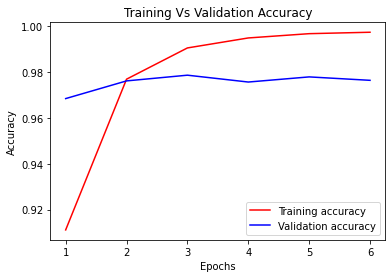

In [24]:
# Taining accuracy Vs Validation accuracy

# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

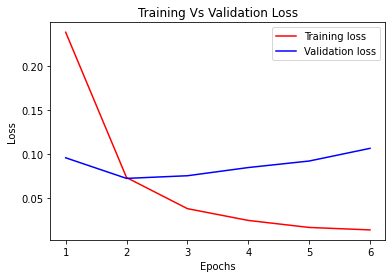

In [25]:
# Taining loss Vs Validation loss

# "r" is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()